## Session 1.2 Regression (Multivariate, real data sets)

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import IPython
import platform

from sklearn import preprocessing

# print ('Python version:', platform.python_version())
# print ('IPython version:', IPython.__version__)
# print ('numpy version:', np.__version__)
# print ('scikit-learn version:', sklearn.__version__)
# print ('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib


## Load your multivariate data

To demonstrate multivariate regression in scikit-learn, we will apply it to a (very) simple and well-know problem: trying to predict the price of a house given some of its characteristics. As the dataset, we will use the 1978 Boston house price dataset (find the dataset description and attributes [here](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)).

This notebook is set up so that you can load some **other datasets** (Cheddar Cheese Tastiness, California House Prices) and also **generate your own** (set gen_data = True).

In [21]:
from sklearn.datasets import make_regression, load_boston, fetch_california_housing
import pandas as pd
gen_data = False
clean_up = True
# data_load = "california"
if not gen_data:
#     for data_load in ["cheese", "boston", "california"]:
    for data_load in ["boston",]:
        if data_load == "cheese":
            print("\nCHEESE")
            data = pd.read_csv("./data/cheddar-cheese.csv")
            print(data)
            X_feature_names = data.columns[1:4]
            y_feature_name = data.columns[-1]
            data = data.values
            X = data[:, 1:4] # all rows (:), columns 1-3 (1:3)
            y = data[:, -1] # just the last column (col 4)

        elif data_load == "boston":
            print("\nBOSTON")
            data_bunch = load_boston() #fetch_california_housing() #load_diabetes()
            print(data_bunch.DESCR)
            X = data_bunch.data 
            y = data_bunch.target
            X_feature_names = data_bunch.feature_names
            y_feature_name = data_bunch.target_names if "target_names" in data_bunch else "target"

            if clean_up:
                X = np.delete(X, -2, axis=1) # remove the dubious "B" feature
                X_feature_names = np.delete(X_feature_names, -2)

                sub_50k_indices = (y < 50) # remove clipped values at the max price ($50k)
                y = y[sub_50k_indices]
                X = X[sub_50k_indices, :]

        elif data_load == "california":
            print("\nCALI")
            data_bunch = fetch_california_housing()
            print(data_bunch.DESCR)
            X = data_bunch.data 
            y = data_bunch.target
            X_feature_names = data_bunch.feature_names
            y_feature_name = data_bunch.target_names if "target_names" in data_bunch else "target"

            if clean_up:
                sub_50k_indices = (y < 5) # remove clipped values at the max price ($50k)
                y = y[sub_50k_indices]
                X = X[sub_50k_indices, :]
else:
    print(gen_data)
    n_f = 10
    n_inf = n_f//3 # this is an integer division ... could also do = int(n_f/10)
    X, y = make_regression(n_samples=100, n_features=n_f, n_informative=n_inf, noise=25, random_state=666)
    X_feature_names = ["Feat.{}".format(f) for f in range(n_f)]
    y_feature_name = "Target"

print(X.shape)
print(y.shape)
print(X_feature_names, y_feature_name)




BOSTON
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTR

## Partition the datasets
This time we'll use sklearn's own utility function to do the dataset partition

In [22]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=666)

np.set_printoptions(precision=2, suppress=True)
print("features:\n", X_train_raw[:,:])

features:
 [[ 14.24   0.    18.1  ... 666.    20.2   20.32]
 [  3.68   0.    18.1  ... 666.    20.2   10.19]
 [  0.1   40.     6.41 ... 254.    17.6    6.05]
 ...
 [ 10.67   0.    18.1  ... 666.    20.2   23.98]
 [  9.6    0.    18.1  ... 666.    20.2   20.31]
 [  0.21  22.     5.86 ... 330.    19.1   12.5 ]]


## Scale your multivariate data
It is important for multivariate data to scale the dataset, in particular when features are measured in wildly different units, since otherwise those with large values will tend to eclipse the smaller ones and skew the result. To make sure data is all with the same ranges, we use a scaler.

Sklearn's StandardScaler transforms all ranges to have a mean of 0 and a std. dev of 1.  Once a scaler has been fit, it can be reused to apply the same scaling again.

Don't forget to scale the test X data as well as the training X data!

In [6]:
from sklearn.preprocessing import StandardScaler

for do_scale in [False, True]:
    # Create our scaled train and test datasets
    if do_scale:
        print("Check the scaled values for mean, std")
        x_scaler = StandardScaler()
        X_train = x_scaler.fit_transform(X_train_raw)
        X_test  = x_scaler.transform(X_test_raw) # we don't re-fit on test data (imagine we've never seen it before...)
    else:
        print("Check the unscaled values for mean, std")
        X_train = X_train_raw
        X_test  = X_test_raw
    
    for s,d in [("train",X_train), ("test",X_test)]:
        print("Feature means ({}):".format(s), numpy.mean(d, axis=0))
        print("Feature stdevs ({}):".format(s), numpy.std(d, axis=0))
        print("---")
        
    y_train = y_train_raw
    y_test = y_test_raw

Check the unscaled values for mean, std
Feature means (train): [  3.65  10.79  11.26   0.05   0.56   6.23  68.     3.79   9.53 410.
  18.55  13.08]
Feature stdevs (train): [  8.65  22.82   6.81   0.23   0.12   0.66  28.56   2.12   8.69 167.28
   2.11   7.16]
---
Feature means (test): [  3.6   12.39  10.52   0.08   0.55   6.31  69.4    4.     9.44 400.01
  18.39  12.3 ]
Feature stdevs (test): [  8.97  22.78   6.81   0.27   0.12   0.63  26.34   2.04   8.65 170.11
   2.08   6.7 ]
---
Check the scaled values for mean, std
Feature means (train): [-0.  0.  0.  0. -0.  0. -0.  0.  0. -0.  0. -0.]
Feature stdevs (train): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
---
Feature means (test): [-0.01  0.07 -0.11  0.12 -0.06  0.13  0.05  0.1  -0.01 -0.06 -0.08 -0.11]
Feature stdevs (test): [1.04 1.   1.   1.22 0.99 0.96 0.92 0.96 0.99 1.02 0.98 0.94]
---


## Training using n-fold cross-validation

Previously we've trained using a dataset split into train and test subsets.  Another way to split your data is to use cross validation.

One of the main advantages of cross-validation is reducing the variance of the evaluation measures.  When you split the data manually, you will find that for each different split, your algorithm's performance will vary.  How do you know what is the right score?

Evaluation within machine learning generally assumes that the distribution of classes on your training and testing sets are similar. If not, you may get results that are not a truthful measure of the classifier's performance. Cross-validation lets us mitigate this: we are averaging on k different models built on k different datasets, so we are reducing variance and probably producing more realistic performance scores for our models.

Another benefit of cross-validation is that it allows us to make good use of the data we have available - each example acts as both a training datapoint and as a validation datapoint.

In [28]:
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_squared_error
def train_and_evaluate(_reg, _X, _y, n_folds=0, refit=False):
    # Estimator objects can be fitted or unfitted.  If the user wants to force a retraining, then we do not need to check the status of the estimator
    if refit==True:
        do_train=True
    else:
        try:
            check_is_fitted(_reg)
            print("Estimator is already fitted: will not train it again!")
            do_train=False
        except:
            do_train=True

    if do_train:
        _reg.fit(_X, _y)
        print ('Score on training set: {:.2f}'.format(_reg.score(_X, _y)))

    if n_folds >= 2: # we need a couple of folds to do cross validation
        cv = sklearn.model_selection.KFold(n_splits= n_folds, shuffle=True, random_state=666)
        scores = sklearn.model_selection.cross_val_score(_reg, _X, _y, cv=cv, scoring="explained_variance")
        av_score = np.mean(scores)
        print ('Average score using {}-fold crossvalidation:{:.2f}'.format(n_folds,av_score))
    else: #otherwise just do a normal scoring
        av_score = sklearn.metrics.explained_variance_score(_reg.predict(_X),_y)
        print("Plain (non-CV) score on X vs y:{:.2f}".format(av_score))
    return _reg, av_score

In [29]:
from sklearn.linear_model import LinearRegression

est = LinearRegression()
train_and_evaluate(est, X_train, y_train, 5) # this will train the estimator and do cross validation
train_and_evaluate(est, X_test, y_test, 0) # this will NOT train a trained estimator, and with n_folds=0 it will also not cross validate

Score on training set: 0.76
Average score using 5-fold crossvalidation:0.74
Estimator is already fitted: will not train it again!
Plain (non-CV) score on X vs y:0.75


(LinearRegression(), 0.7527415164268111)

## Feature selection with a correlation matrix
Create a correlation matrix to help us pick out the most relevant factors.  We want those with the biggest (negative or positive) correlation with median value, MEDV.

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'LSTAT']


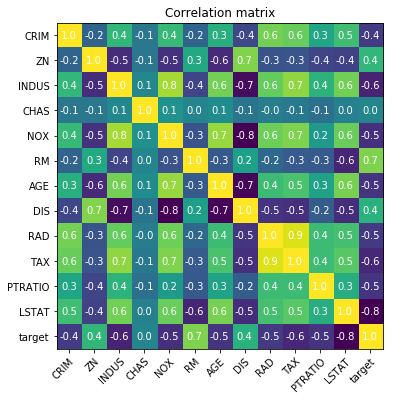

In [25]:
correlation_matrix = numpy.corrcoef(X_train.T, y_train)
fig, ax = plt.subplots()
im = ax.imshow(correlation_matrix)

print(X_feature_names)
feat_names = [str(x) for x in X_feature_names] + [y_feature_name] # concatenate these two lists

mx_dim = X_train.shape[1]+1
# # We want to show all ticks...
ax.set_xticks(np.arange(mx_dim))
ax.set_yticks(np.arange(mx_dim))
# # ... and label them with the respective list entries
ax.set_xticklabels(feat_names)
ax.set_yticklabels(feat_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(mx_dim):
    for j in range(mx_dim):
        text = ax.text(j, i, round(correlation_matrix[i, j],1),
                       ha="center", va="center", color="w")

ax.set_title("Correlation matrix")
# fig.tight_layout()
fig.set_size_inches(6,6)
plt.show()


## Automatic feature selection
Sklearn lets us automatically test (F-test!) and select the K best features for explaining variance in the dataset...

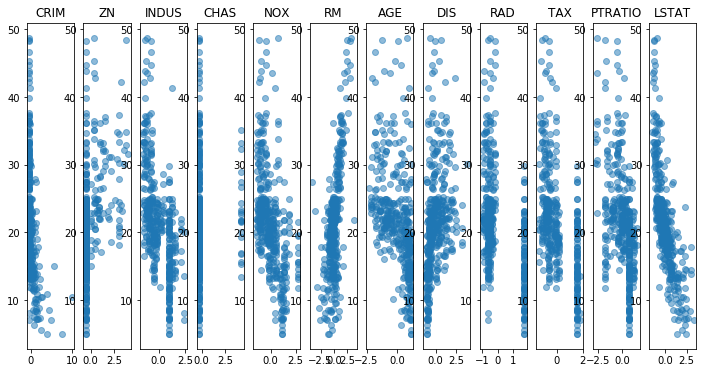

[11  5  2  9  4] [0. 0. 0. 0. 0.]


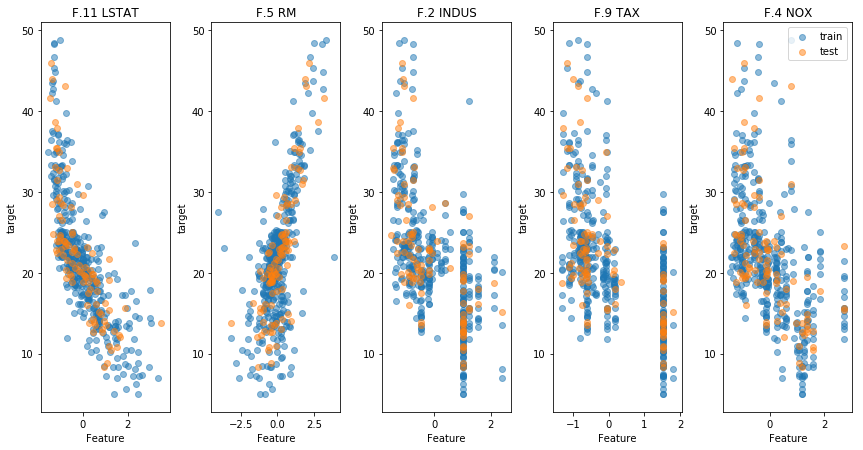

In [30]:
from sklearn.feature_selection import * # bad python, don't do this :)
k=5

np.set_printoptions(precision=4)

fs=SelectKBest(score_func=f_regression,k=k)
X_new=fs.fit_transform(X_train,y_train)
X_test_new = fs.transform(X_test)

# X_new = X_train #uncomment to keep all the features
# X_test_new = X_test

fig, axes = plt.subplots(1, X.shape[1])
fig.set_size_inches(12,6)
for i in range(X.shape[1]):
    axes[i].set_aspect('auto')
    axes[i].scatter(X_train[:,i], y_train, alpha=0.5)
    axes[i].set_title(X_feature_names[i])
plt.show()
columns_to_keep = np.argsort(fs.pvalues_)[0:k]
print(columns_to_keep, fs.pvalues_[columns_to_keep])

# Two subplots, unpack the axes array immediately
if k >1:
    fig, axes = plt.subplots(1,k)
else:
    fig = plt.gcf()
    axes = [plt.gca()]
    
fig.set_size_inches(12,6)
# fig, axes = plt.subplots(1, X.shape[1])
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.1)
fig.tight_layout()
sneaky_peek = True
if k>0:
    for i, f_idx in enumerate(columns_to_keep):
        axes[i].set_aspect('auto')
        axes[i].set_title('F.' + str(f_idx) + " " + X_feature_names[f_idx])
        axes[i].set_xlabel('Feature')
        axes[i].set_ylabel(y_feature_name)
        fig.sca(axes[i])
        axes[i].scatter(X_train[:,f_idx],y_train, alpha=0.5, label="train")
        if sneaky_peek:
            axes[i].scatter(X_test[:,f_idx],y_test, alpha=0.5, label="test")
plt.legend()
plt.show()

## Searching for new non-linear features


In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# print("\nSVR RBF (Top 5)")
# svr_rbf = svm.SVR(kernel="rbf")#, degree=2)#, gamma="auto")
# train_and_evaluate(svr_rbf, X_new, y_train, 5)

def poly_features_param_search(_est, _X,_y, _X_test, _y_test):
    best = (None, None, -math.inf, -math.inf)
    for deg in [1,2,3,4]:
        for inter_only in [False, True]:
            polyfeat = PolynomialFeatures(degree=deg, interaction_only=inter_only)
            X_f = polyfeat.fit_transform(_X)
            X_f_test = polyfeat.transform(_X_test)
            _est, sc_tr = train_and_evaluate(_est, X_f, _y, 5, refit=True)
            if sc_tr > best[2]:
                print("New best on training")
                print("\t", end="")
                _est, sc_tt = train_and_evaluate(_est, X_f_test, _y_test, 0, refit=False)
                best = (deg, inter_only, sc_tr, sc_tt)
    print(best)
    return best

In [20]:
est = LinearRegression()
poly_features_param_search(est, X_train, y_train, X_test, y_test)
print("~~~~\n")
ptx = PolynomialFeatures(2, interaction_only=True)
X_poly = ptx.fit_transform(X_train)
X_test_poly = ptx.transform(X_test)

Score on training set: 0.76
Average score using 5-fold crossvalidation:0.74
New best on training
	Estimator is already fitted: will assume you are using the test set and not train it again!
Plain (non-CV) score on X vs y:0.75
Score on training set: 0.76
Average score using 5-fold crossvalidation:0.74
Score on training set: 0.92
Average score using 5-fold crossvalidation:0.83
New best on training
	Estimator is already fitted: will assume you are using the test set and not train it again!
Plain (non-CV) score on X vs y:0.82
Score on training set: 0.91
Average score using 5-fold crossvalidation:0.85
New best on training
	Estimator is already fitted: will assume you are using the test set and not train it again!
Plain (non-CV) score on X vs y:0.88
Score on training set: 1.00
Average score using 5-fold crossvalidation:-54563.13
Score on training set: 0.96
Average score using 5-fold crossvalidation:-298.54
Score on training set: 1.00
Average score using 5-fold crossvalidation:-9852.00
Score 

In [ ]:
## Trying some non-linear regression

## Extra
Use a _non-linear_ regressor such as sklearn's SVR, and cross validate it on the Boston data.  Is it better?  If so, why might this be?  What about on the test dataset?

In [32]:
all_feats = "All features"
top_feats = "Top features only"

dataset_lookup = {}
dataset_lookup[all_feats] = (X_train, X_test)
dataset_lookup[top_feats] = (X_poly, X_test_poly)
dataset_lookup["target"] = (y_train, y_test)

from sklearn import svm, neighbors, tree
svr_linear = svm.SVR(kernel="linear")
svr_rbf = svm.SVR(kernel="rbf")
knn = neighbors.KNeighborsRegressor()
dtr = tree.DecisionTreeRegressor()
est_list = [svr_linear, svr_rbf, knn, dtr]

for est in est_list:
    for feats_name in [all_feats, top_feats]:
        X_tr, X_tt = dataset_lookup[feats_name]
        y_tr, y_tt = dataset_lookup["target"]
        print(X_tr.shape, X_tt.shape)
        print(y_tr.shape, y_tt.shape)
        print("{}, {}".format(est.__class__.__name__, feats_name))
#         for k,v in est.get_params().items():
#             print("\t{}:{}".format(k,v))
        train_and_evaluate(est, X_tr, y_tr, 5, refit=True)
        train_and_evaluate(est, X_tt, y_tt, 0, refit=False)
        print()
    print("~~~\n")


(392, 12) (98, 12)
(392,) (98,)
SVR, All features
Score on training set: 0.75
Average score using 5-fold crossvalidation:0.74
Estimator is already fitted: will not train it again!
Plain (non-CV) score on X vs y:0.74

(392, 79) (98, 79)
(392,) (98,)
SVR, Top features only
Score on training set: 0.89
Average score using 5-fold crossvalidation:0.86
Estimator is already fitted: will not train it again!
Plain (non-CV) score on X vs y:0.88

~~~

(392, 12) (98, 12)
(392,) (98,)
SVR, All features
Score on training set: 0.77
Average score using 5-fold crossvalidation:0.72
Estimator is already fitted: will not train it again!
Plain (non-CV) score on X vs y:0.58

(392, 79) (98, 79)
(392,) (98,)
SVR, Top features only
Score on training set: 0.67
Average score using 5-fold crossvalidation:0.58
Estimator is already fitted: will not train it again!
Plain (non-CV) score on X vs y:0.03

~~~

(392, 12) (98, 12)
(392,) (98,)
KNeighborsRegressor, All features
Score on training set: 0.87
Average score usin

## Summary
- We tried out multivariate regression on the Boston house price dataset, using k-fold cross validation to test our estimators
- We tried some feature selection using a correlation matrix and SelectKBest
- We used the PolynomialFeatures transformer to construct new polynomial feature sets that can model curves and created a simple parameter search routine to optimise the polynomial degree, and interaction features.